## Notebook: Parole Hearings - Commiting Errors When Analyzing Sensible Data

Parole hearing in the state of New York

The focus of this dataset is to study fairness according to perp location.

Some questions we can raise over this dataset:
   - It is possible to predict all many years a perp will stay in prison ?
   - Do the perp's race interferes in his/her sentence ?
       - The gender interferes ?
       - The neighborhood his comming from ?
   - Where most crimes happen ?
       - Are in poor or rich counties ?

Datasets link: https://www.kaggle.com/parole-hearing-data/parole-hearings-in-new-york-state

### Dataset Dictionary

Here we will specify only the non-intutive features

- DIN: is assigned to each offender admitted to the Department of Correctional Services. This is an internal number used as an identifier for the offender while he or she is in the custody of the Department.
- Housing or Interview Facility: This shows the Correctional Facility where the offender is being housed before his/her Board appearance. Interview facility shows the place where the interview was held. 
- Housing/Release facility: is the place where the offender was released from.
- Release Type: This is the circumstance under which the offender is released from a Correctional Facility.
- Release Date: The date an offender is released from a Correctional Facility prior to the maximum expiration date.
- Parole eligibility Date: Under certain circumstances, an offender may be released prior to serving his or her minimum term. 
- Aggregated Minimum / Maximum Sentence: These fields contain an aggregate of the amount of time the offender must serve for the crimes for which he or she was committed. (year months - year months)
- Maximum Expiration Date: If an offender is not released by the Parole Board or by conditional release, he or she will remain in custody until his or her maximum expiration date. The offender's sentence is deemed completed as of this date.
- Post Release Supervision me Date: ndicates how long the offender may be under post release supervision.
- Parole Board Discharge Date: This indicates the offender has been discharged from parole supervision before the maximum expiration date or the maximum expiration date for parole supervision.
- Parole Interview Type: This indicates the type of the next appearance by the offender before the Parole Board. It may be his or her initial appearance, reappearance, or a variety of other hearing types.
- Parole Me Date: ??


Taken from: http://www.doccs.ny.gov/calendardatadefinitions.html



### Evaluated Boroughs

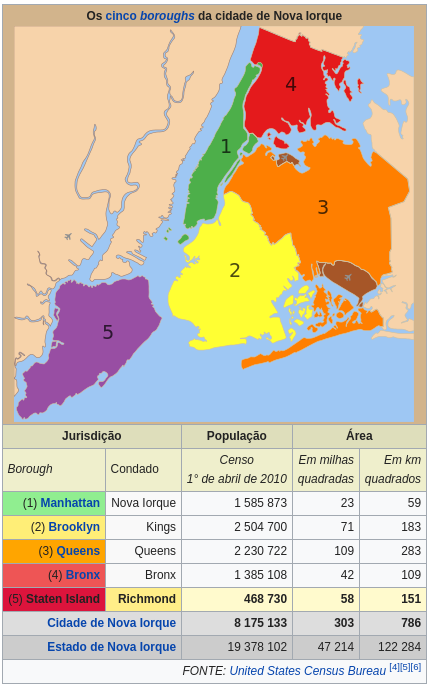

In [7]:
from IPython.display import Image
Image("Aux/evaluated_boroughs.png")

In [1]:
import pandas as pd

In [2]:
df = pd.read_table("Input/data.csv", sep = ',')

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (34,35,36,37,38,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Auxiliary Function: Count Instances

In [5]:
def count_instances(df, feature):
    return list(map(lambda x: {x: len(df[df[feature] == x])}, set(df[feature])))

### Auxiliary Function: Count NaN

In [4]:
def count_nan(df):
    for col in df.columns:
        if df[col].isna().values.any():
            print(col, df[col].isna().sum(), round(df[col].isna().sum()/len(df), 5))

count_nan(df)

year of entry 39295 0.90294
aggregated minimum sentence 197 0.00453
aggregated maximum sentence 197 0.00453
release date 20084 0.4615
release type 21983 0.50514
housing/release facility 197 0.00453
parole eligibility date 407 0.00935
conditional release date 6 0.00014
maximum expiration date 6 0.00014
parole me date 12 0.00028
post release supervision me date 33487 0.76948
parole board discharge date 37321 0.85758
crime 1 - crime of conviction 199 0.00457
crime 1 - class 199 0.00457
crime 1 - county of commitment 199 0.00457
crime 2 - crime of conviction 25715 0.59089
crime 2 - class 25715 0.59089
crime 2 - county of commitment 25715 0.59089
crime 3 - crime of conviction 36332 0.83485
crime 3 - class 36332 0.83485
crime 3 - county of commitment 36332 0.83485
crime 4 - crime of conviction 40016 0.91951
crime 4 - class 40016 0.91951
crime 4 - county of commitment 40016 0.91951
crime 5 - crime of conviction 43517 0.99995
crime 5 - class 43518 0.99998
crime 5 - county of commitment 43518 0

### Pre-Processing: Removing Useless Rows and Columns

In [5]:
pd.set_option('display.max_columns', 500)
print(df.head(5))
# removing columns with useless informartion or with many NaN values
df = df.drop(['year of entry', 'scrape date'],  axis=1)
# removing instances with NaN values
columns_instances = ['aggregated minimum sentence', 'aggregated maximum sentence']
df.dropna(axis=0, subset=columns_instances, inplace=True)
for feature in columns_instances:
    df = df[df[feature].str.contains("-")]

  parole board interview date      din scrape date      nysid   sex  \
0                           *  00A1838  2014-08-05  09475883Z  MALE   
1                           *  00A2973  2014-08-05  08920738Z  MALE   
2                           *  00A5417  2015-01-28  08334050Z  MALE   
3                           *  00B1222  2015-01-28  08978047Q  MALE   
4                           *  00B2067  2015-01-28  03268987Y  MALE   

   birth date race / ethnicity housing or interview facility  \
0  2063-08-24            WHITE                      FRANKLIN   
1  1973-08-05         HISPANIC                       COLLINS   
2  1980-03-04            BLACK                        AUBURN   
3  1982-02-01            BLACK                     GROVELAND   
4  1953-11-03         HISPANIC                        ELMIRA   

  parole board interview type interview decision  year of entry  \
0                    PV REAPP                  *            0.0   
1                    PV REAPP                  *      

### New Field: Number of Commited Crimes

Aggregating the crimes commited.

In [6]:
crimes_columns = [feature for feature in df.columns if 'crime of conviction' in feature]
crime_counter = []
for _, instance in df.iterrows():
    crime_counter.append(len(list(filter(lambda x: isinstance(instance.loc[x], str), crimes_columns))))

df['Number of Crimes'] = crime_counter

### Selecting only Perps that at least only crime was within New York City 

In [7]:
boroughs = ['NEW YORK', 'KINGS', 'QUEENS', 'BRONX', 'RICHMOND']
df = df.loc[(df['crime 1 - county of commitment'].isin(boroughs))]

### Removing invalid rows

The remove rows do not aggregate much for our analyzes, given that it not contain must of the features.

In [8]:
df = df.loc[
        (df['parole board interview date'] != '*') & 
        (df['interview decision'] != '*') &
        (df['interview decision'] != '**********')
        ]

### Parsing Date 

In [9]:
date, token = [], 'parole board interview date'
for _, instance in df.iterrows():
    date.append('-'.join(instance[token].split('-')[:2]))
df[token] = date

### Parsing Aggregated Minimum / Maximum sentence

- Making new columns: Min. / Max. Sentence Month, Min. / Max. Sentence Years

In [10]:
token_min = 'aggregated minimum sentence'
token_max = 'aggregated maximum sentence'
year_max, year_min, month_max, month_min = [], [], [], []
invalid_rows = []

for index, instance in df.iterrows():

    year_max.append(instance[token_max].split('-')[0])
    month_max.append(instance[token_max].split('-')[1])

    year_min.append(instance[token_min].split('-')[0])
    month_min.append(instance[token_min].split('-')[1])

    
df['Max Sentence Month'] = month_max
df['Max Sentence Year'] = year_max

df['Min Sentence Month'] = month_min
df['Min Sentence Year'] = year_min

df.drop([token_min, token_max], axis=1)

,parole board interview date,din,nysid,sex,birth date,race / ethnicity,housing or interview facility,parole board interview type,interview decision,release date,release type,housing/release facility,parole eligibility date,conditional release date,maximum expiration date,parole me date,post release supervision me date,parole board discharge date,crime 1 - crime of conviction,crime 1 - class,crime 1 - county of commitment,crime 2 - crime of conviction,crime 2 - class,crime 2 - county of commitment,crime 3 - crime of conviction,crime 3 - class,crime 3 - county of commitment,crime 4 - crime of conviction,crime 4 - class,crime 4 - county of commitment,crime 5 - crime of conviction,crime 5 - class,crime 5 - county of commitment,crime 6 - crime of conviction,crime 6 - class,crime 6 - county of commitment,crime 7 - crime of conviction,crime 7 - class,crime 7 - county of commitment,crime 8 - crime of conviction,crime 8 - class,crime 8 - county of commitment,Number of Crimes,Max Sentence Month,Max Sentence Year,Min Sentence Month,Min Sentence Year
660,2012-08,03B2727,08868271Z,MALE,1981-06-07,BLACK,LIVINGSTON,INITIAL,DENIED,2013-03-29,CR,LIVINGSTON,2012-11-30,2013-03-31,2014-05-06,2018-03-29,2018-03-29,2015-01-13,BURGLARY-1>78,B,MONROE,ATT ASSAULT-2,E,JEFFERSON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,11,06,00,00
661,2012-08,04A5142,04919051Z,MALE,2056-03-28,BLACK,LIVINGSTON,INITIAL,DENIED,2012-11-02,CR,LIVINGSTON,2012-11-03,2012-11-03,2014-04-09,2017-11-02,2017-11-02,2014-02-11,BURGLARY-2,C,ALBANY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,00,10,08,06
662,2012-08,05B0786,04281357Q,MALE,2059-04-19,WHITE,LIVINGSTON,REAPPEAR,DENIED,2012-11-21,CR,LIVINGSTON,2008-11-19,2012-11-19,2016-11-19,2016-11-19,2015-01-13,2015-01-13,RAPE-3,E,CHENANGO,CRIM SEX ACT 3,E,CHENANGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,00,04,04,01
663,2012-08,09B2160,08883878R,MALE,1981-07-16,BLACK,LIVINGSTON,REAPPEAR,DENIED,2012-11-21,CR,LIVINGSTON,2010-11-22,2012-11-22,2014-11-22,2014-11-22,2015-01-13,2015-01-13,RAPE-2,D,ERIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,00,06,00,02
664,2012-08,10A0062,05705635M,MALE,1971-02-16,BLACK,ADIRONDACK,INITIAL,DENIED,2014-01-15,CR,QUEENSBORO,2012-11-15,2014-01-15,2016-05-15,2016-05-15,2015-01-13,2015-01-13,GRAND LARCENY-3,D,QUEENS,ATT CP FORG INST-1,D,NEW YORK,CP FORG INST-2,D,NASSAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,00,07,06,03
665,2012-08,10A0747,04095891P,MALE,2060-11-09,BLACK,ADIRONDACK,REAPPEAR,OPEN DATE,2012-09-13,BOARD,ADIRONDACK,2010-11-02,NONE,LIFE SENTENCE,LIFE SENTENCE,2015-01-13,2015-01-13,ATT CPW-3/NON-VFO,E,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,00,03,06,01
666,2012-08,10A3408,06737683P,MALE,2058-08-02,HISPANIC,LIVINGSTON,ECPDO,GRANTED,2012-08-29,BOARD,ORLEANS,2015-01-13,2013-10-20,2014-07-10,2017-08-29,2017-08-29,2015-01-13,CPCS-2,A,NEW YORK,CPCS-2,A,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,00,05,00,00
667,2012-08,10B0930,06750206L,MALE,1974-09-16,BLACK,LIVINGSTON,MERIT TIME,OR EARLIER,2015-01-13,NaN,LIVINGSTON,2013-05-13,2013-09-21,2014-05-17,2014-05-17,2015-01-13,2015-01-13,CPCS-5 >79,D,CHEMUNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,06,03,11,02
668,2012-08,10B2999,02984681Q,MALE,1982-12-15,BLACK,LIVINGSTON,INITIAL,DENIED,2015-01-13,NaN,BARE HILL,2012-11-07,2015-03-07,2017-07-07,2017-07-07,2015-01-13,2015-01-13,CP FORG INST-2,D,MONROE,LV ACCDNT DEATH,D,MONROE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,00,07,04,02
669,2012-08,10B3660,08753623Y,MALE,1981-08-30,WHITE,LIVINGSTON,INITIAL,DENIED,2015-01-13,NaN,LIVINGSTON,2012-11-22,2014-11-22,2016-11-22,2016-11-22,2015-01-13,2015-01-13,DWI 2ND OFF,E,ORLEANS,DWI 2ND OFF,E,ORLEANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
set(df['housing or interview facility'])

{'ADIRONDACK',
 'ALBION',
 'ALBION-FEMALE',
 'ALBION-WR',
 'ALTONA',
 'ATTICA',
 'AUBURN',
 'BARE HILL',
 'BAYVIEW',
 'BEACON-FEMALE',
 'BEDFORD HILLS',
 'BUTLER-ASACTC',
 'CAPE VINCENT',
 'CAYUGA',
 'CLINTON',
 'COLLINS',
 'COXSACKIE',
 'DOWNSTATE',
 'EASTERN',
 'EDGECOMBE',
 'ELMIRA',
 'FISHKILL',
 'FIVE POINTS',
 'FRANKLIN',
 'GOSHEN',
 'GOUVERNEUR',
 'GOWANDA',
 'GOWANDA SOP',
 'GREAT MEADOW',
 'GREEN HAVEN',
 'GREENE',
 'GROVELAND',
 'HALE CREEK-ASAC',
 'HUDSON',
 'LAKEVIEW',
 'LAKEVIEW-FEMALE',
 'LAKEVIEW-SHOCK',
 'LINCOLN',
 'LIVINGSTON',
 'MARCY',
 'MARCY-ASACTC',
 'MIDSTATE',
 'MOHAWK',
 'MORIAH',
 'MT. MCGREGOR',
 'NYC-OTHER',
 'OGDENSBURG',
 'ORLEANS',
 'OTHER AGENCY',
 'OTISVILLE',
 'QUEENSBORO',
 'RIVERVIEW',
 'ROCHESTER',
 'SHAWANGUNK',
 'SING SING',
 'SOUTHPORT',
 'SULLIVAN',
 'TACONIC-ASACTC',
 'TACONIC-FEMALE',
 'ULSTER',
 'UNKNOWN',
 'UPSTATE',
 'WALLKILL',
 'WALSH MED CNTR',
 'WASHINGTON',
 'WATERTOWN',
 'WENDE',
 'WOODBOURNE',
 'WYOMING'}

### Tasks:
    - Make a column with a estimative of when the criminal was arrested